# Tutorial 2 - Inferring Protein Activity from scRNA-seq data from multiple cell populations with the meta-VIPER approach

This tutorial explores the use of metaVIPER to assess protein activity by integrative analysis using multiple gene regulatory networks. metaVIPER is particularly useful in real-world scenarios to infer protein activity in a tissue-independent manner by using multiple, non-tissue-matched interactomes, assuming that transcriptional targets of each protein can be recapitulated by one or more available interactomes. The `viper` function allows running metaVIPER using both [aREA](https://www.nature.com/articles/ng.3593) and [NaRnEA](https://www.mdpi.com/1099-4300/25/3/542) enrichment methods. For additional details, please refer to [Ding et al., 2016](https://www.nature.com/articles/s41467-018-03843-3).

<code style="background:lightgreen;color:black">Add part on enrichment.</code>


### Install Pyviper
Install `pyviper` from PyPI using pip. Alternatively, refer to the README in the current GitHub to install from the local directory.

In [1]:
# !pip install pyviper

### Import modules

In [2]:
import pyther
import scanpy as sc
import anndata 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*") # for jit decorator issue with sc.pp.neighbors (09/30/2023)

### Step 1. Load a gene expression matrix and associated metadata  
Load the gene expression matrix (UMIs) and store it into an [AnnData](https://anndata.readthedocs.io/en/latest/) object to enable interoperability with [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/#). Cells used in this tutorial were sampled from scRNA-seq data published in [Peng et al., 2019](https://www.nature.com/articles/s41422-019-0195-y).  

In [3]:
# gExpr_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/T11_subset.tsv"  # where gene expression matrix (UMI counts) is located
gExpr_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/d1_d2_f_subset_6500.tsv" # path to gene expression matrix (UMI counts)
adata_gExpr = sc.read(gExpr_path).T

Display matrix dimensions (cells x genes)

In [4]:
adata_gExpr

AnnData object with n_obs × n_vars = 6500 × 24005

Load cell-associated metadata

In [5]:
#metadata_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/T11_metadata.tsv"  # where cells metadata are located
metadata_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/d1_d2_f_metadata_6500.tsv" # path to cells metadata
cells_metadata = pd.read_csv(metadata_path, sep="\t")  # load it

Store the metadata in the `adata_gExpr` object as observation annotation.

In [6]:
adata_gExpr.obs = pd.merge(adata_gExpr.obs, cells_metadata, how="left",left_index=True, right_index=True) # store cell-specific metadata as annotation observation

Display the observation annotation from the AnnData object.

In [7]:
adata_gExpr.obs.head()

,Patient,Cell_Type
T1_AAACCTGAGATGTCGG,T1,Fibroblast cell
T1_AACACGTCAATGACCT,T1,Ductal cell type 2
T1_AACCATGTCTGTCCGT,T1,Ductal cell type 2
T1_AACCGCGTCGAATGGG,T1,Ductal cell type 2
T1_AACGTTGCAATGGATA,T1,Stellate cell


The observation annotations include the patient from which each cell was sequenced and the annotated cell type.
List the cell types.

In [8]:
adata_gExpr.obs.groupby('Cell_Type').size().reset_index(name='n') # show cell types and number of cells for each type in AnnData

,Cell_Type,n
0,Ductal cell type 1,690
1,Ductal cell type 2,2938
2,Fibroblast cell,1477
3,Stellate cell,1395


Data contain <span style="color:red">4</span> cells types: Ductal cells of type 1 and 2 (non-transformed and malignant, respectively), Fibroblasts and Stellate cells (myofibroblast-like cells).

### Step 2. Preprocess and generate a gene expression signature at the single-cell level

The UMI matrix can be processed using the standard `Scanpy` preprocessing workflow. Since the quality of the provided data was pre-assessed and found to be high, cell filtering will be minimal. For a more detailed explanation of QC steps, refer to the preprocessing tutorials bt [Scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) or [Seurat](https://satijalab.org/seurat/articles/pbmc3k_tutorial). 

In [9]:
sc.pp.filter_cells(adata_gExpr, min_genes=200) # filter out cells with <200 genes expressed
sc.pp.filter_genes(adata_gExpr, min_cells=3) # filter out genes that are detected in <3 cells

Display matrix dimensions post-filtering (cells x genes) 

In [10]:
adata_gExpr

AnnData object with n_obs × n_vars = 6500 × 20931
    obs: 'Patient', 'Cell_Type', 'n_genes'
    var: 'n_cells'

Normalize the gene expression matrix by the total number of UMIs to 10,000 UMIs per cells to make each gene expression comparable across cells and log-transform the normalized counts. Then, store the log-normalized counts in the `.raw` attribute of the `AnnData` object

In [11]:
sc.pp.normalize_total(adata_gExpr, target_sum=1e4) # normalize counts
sc.pp.log1p(adata_gExpr) # log-transform the counts
sc.pp.calculate_qc_metrics(adata_gExpr, percent_top=None, log1p=False, inplace=True) # compute some statistics, e.g. total_counts, n_cells_by_counts etc 

adata_gExpr.raw = adata_gExpr   # store log-normalized counts to .raw Attribute for potential future use

Generate a gene expression signature on a single-cell basis by scaling each gene to unit variance. This scaled matrix will be used as an input to `pyther` to compute the protein activity matrix. Several approaches exist for the purpose, including computing a reference with respect to an external reference or using models such as [SCTransform](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1). We will employ the simplest approach for demonstrative purposes. 

In [12]:
sc.pp.regress_out(adata_gExpr, 'total_counts') # regress out the effect of the total number of UMIs
sc.pp.scale(adata_gExpr, max_value=10) # standardize gene expression and clip max values to 10

In [13]:
adata_gExpr

AnnData object with n_obs × n_vars = 6500 × 20931
    obs: 'Patient', 'Cell_Type', 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'log1p'

Display a chunk of the scaled matrix (signature)

In [14]:
adata_gExpr[1:5,1:7].to_df()

,AP006222.2,RP11-206L10.3,RP11-206L10.2,RP11-206L10.9,LINC00115,FAM41C
T1_AACACGTCAATGACCT,-0.366852,-0.107912,-0.064235,-0.081443,-0.186370,-0.112861
T1_AACCATGTCTGTCCGT,-0.320497,-0.086591,-0.066305,-0.071187,-0.147921,-0.067329
T1_AACCGCGTCGAATGGG,-0.306291,-0.080056,-0.066939,-0.068043,-0.136138,-0.053375
T1_AACGTTGCAATGGATA,-0.315497,-0.084291,-0.066528,-0.070080,-0.143774,-0.062418


### Step 3. Load multiple ARACNe-inferred gene regulatory networks 
Load 4 lineage-specific gene regulatory network generated with the ARACNe. These networks were generated from malignant and normal ductal cells, fibroblasts and stellate cells, respectively. Refer to the [ARACNe3](https://www.mdpi.com/1099-4300/25/3/542) and [ARACNe-AP](https://pubmed.ncbi.nlm.nih.gov/27153652/) manuscripts for additional information. 
<code style="background:lightgreen">Fix paths</code>

In [15]:
d1_net_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/pruned_Ductal_1.tsv" # path to ARACNe network for ductal 1 
d2_net_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/pruned_Ductal_2.tsv" # path to ARACNe network for ductal 2
f_net_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/pruned_Fibro.tsv" # path to ARACNe network for fibroblasts
s_net_path = "/Users/lucazanella7/Desktop/ColumbiaProjects/pyther_test_data/subset_Peng/pruned_Stellate.tsv" # path to ARACNe network for stellate cells

ductal_1_net = pyther.Interactome('ductal_1',net_table=d1_net_path) # load interactome for ductal cell type 1
ductal_2_net = pyther.Interactome('ductal_2',net_table=d2_net_path) # load interactome for ductal cell type 2
fibroblast_net = pyther.Interactome('fibroblast',net_table=f_net_path) # load interactome for fibroblasts
stellate_net = pyther.Interactome('stellate',net_table=f_net_path) # load interactome for stellate cells

Each regulatory network is an instance of class `Interactome`:

In [16]:
?fibroblast_net

Type:           Interactome
String form:   
Object of class Interactome:
	Name: fibroblast	Number of Regulons: 6437
File:           ~/Desktop/ColumbiaProjects/pyther/pyther/interactome.py
Docstring:      <no docstring>
Init docstring:
Create an Interactome object to contain the results of ARACNe.

Parameters
----------
name
    A filepath to one's disk to store the Interactome.
net_table (default: None)
    Either
    (1) a pd.DataFrame containing four columns in this order:
        "regulator", "target", "mor", "likelihood"
    (2) a filepath to this pd.DataFrame stored either as a .csv,
    .tsv or .pkl.
    (3) a filepath to an Interacome object stored as a .pkl.
input_type (default: None)
    Only relevant when net_table is a filepath. If None, the input_type
    will be inferred from the net_table. Otherwise, specify "csv", "tsv"
    or "pkl".

Due to the expected similarity between fibroblasts and stellate cells in terms of their regulatory networks, we integrate their corresponding interactomes, thus generating a consensus network. 

In [126]:
fibroblast_net.integrate(stellate_net, normalize_likelihoods=True)

Optionally, save the integrated interactome as a .tsv file if needed for later use, by uncommenting the following line.

In [125]:
#fibroblast_net.save("fibroblast_integrated.tsv", output_type="tsv")

Filter out targets in the `Interactomes` that are not present in the gene expression matrix 

In [127]:
ductal_1_net.filter_targets(adata_gExpr.var_names)
ductal_2_net.filter_targets(adata_gExpr.var_names)
fibroblast_net.filter_targets(adata_gExpr.var_names)

Prune each regulon to have exactly 200 targets (this step can be omitted when setting `enrichment=narnea` in `pyther`)

In [128]:
ductal_1_net.prune(max_targets=200,eliminate=True)
ductal_2_net.prune(max_targets=200,eliminate=True)
fibroblast_net.prune(max_targets=200,eliminate=True)

### Convert the gene expression signature into a protein activity matrix using pyther (metaVIPER approach)
Convert the previously-computed gene expression signature into a protein activity by using multiple interactomes simultaneousely via the metaVIPER approach. Use `enrichment="narnea"` and store the result in an `AnnData` object (default). Use 3 cores to speed up the calculation. See Tutorial-1 for details on the available modalities to compute enrichment. <code style="background:lightgreen">consider mentioning slice_concat function here if the matrix used has more cells?</code>

In [129]:
adata_PA = pyther.viper(gex_data=adata_gExpr, # gene expression signature
                            interactome=[ductal_1_net, ductal_2_net, fibroblast_net], # list of interactomes
                            enrichment = "narnea",
                            njobs=3, # 3 cores
                            verbose=False)

`pyther` (NaRnEA-enrichment) returns an object of class `AnnData` that stores a matrix collecting the Normalized Enrichment Scores (NES) and a matrix of Proportional Enrichment Scores (PES) for regulatory protein in each cell. See <span style="color:red">Tutorial 1</span> for more details and [Griffin et al., 2022](https://pubmed.ncbi.nlm.nih.gov/36981431/).

In [130]:
adata_PA

AnnData object with n_obs × n_vars = 6500 × 6667
    obs: 'Patient', 'Cell_Type', 'n_genes', 'n_genes_by_counts', 'total_counts'
    uns: 'gex_data'
    layers: 'pes'

### Step 4. Analyze single-cells at the Protein Activity level 
We present some basic, but instructive analyses at the protein activity matrix. Start by running Principal Components Analysis (PCA) on the PES matrix, to reduce the dimensionality of the dataset. Use the PCA function avaiable through `pyther.tl`, a module that provides several wrappers to `scanpy.tl` which simplifies the transformation of protein activity data. Unlike Tutorial 1, we compute PCA using all available transcription factors, cofactors, signaling and surface proteins.

<code style="background:lightgreen">Bug must be fixed in the following function for filtering by feature_groups. </code>


In [131]:
pyther.tl.pca(adata_PA, layer="pes", filter_by_feature_groups=['tfs', 'cotfs', 'sig', 'surface'], svd_solver='arpack')

Compute the neighbors graph of cells using the PCA representation of the protein activity matrix. For sake of simplicity, we set 10 nearest neightbors and 50 principal components. Typically, these parameters need tuning.

In [139]:
sc.pp.neighbors(adata_PA, n_neighbors=20, n_pcs=50)

Generate a [UMAP](https://arxiv.org/abs/1802.03426) embedding of the previously computed graph.

In [140]:
sc.tl.umap(adata_PA)

Display the 2-dimensional UMAP embedding and color by cell type.  

/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


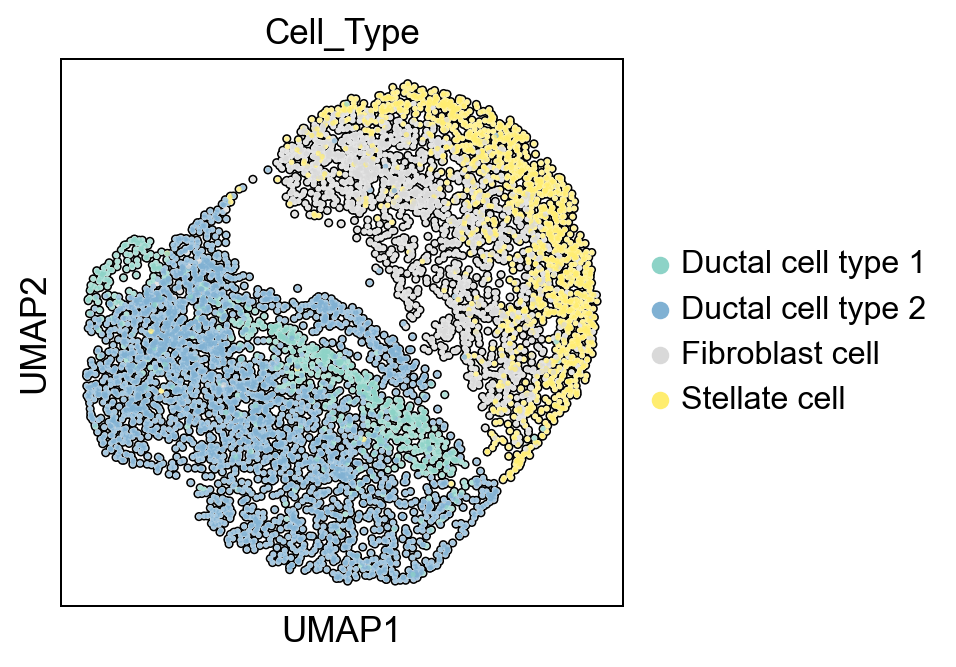

In [142]:
sc.set_figure_params(dpi=90)
pyther.pl.umap(adata_PA,color="Cell_Type", palette="Set3", add_outline=True)

Show the activity of selected markers for of ductal cells and fibroblasts.

/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


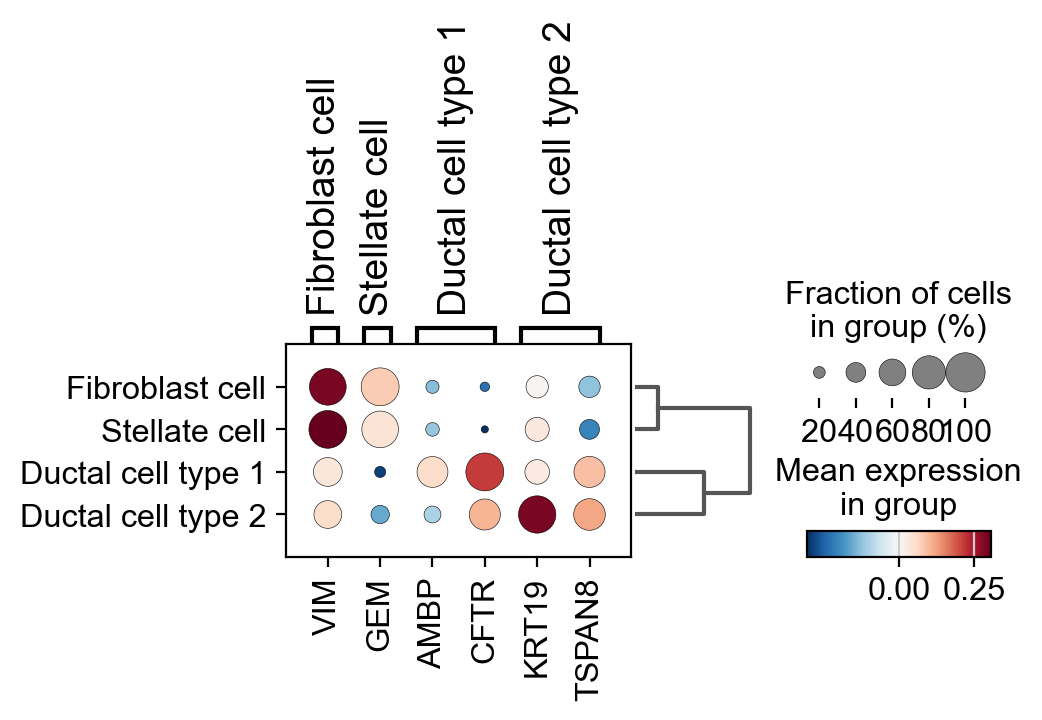

In [143]:
protein_markers_dict = {
    'Ductal cell type 1': ['AMBP', 'CFTR'],
    'Ductal cell type 2': ['KRT19', 'TSPAN8'],
    'Fibroblast cell': ['VIM'],
    'Stellate cell': ['GEM']
}
sc.set_figure_params(dpi=100)
pyther.pl.dotplot(adata_PA, var_names=protein_markers_dict, layer="pes", groupby='Cell_Type', cmap="RdBu_r", vcenter=0,dendrogram=True)

In [144]:
adata_PA

AnnData object with n_obs × n_vars = 6500 × 6667
    obs: 'Patient', 'Cell_Type', 'n_genes', 'n_genes_by_counts', 'total_counts'
    uns: 'gex_data', 'neighbors', 'umap', 'Cell_Type_colors', 'dendrogram_Cell_Type'
    obsm: 'X_pca', 'X_umap'
    layers: 'pes'
    obsp: 'distances', 'connectivities'

Compute differentially active regulatory proteins between malignant (Ductal cell type 2) and normal (Ductal cell type 1) 

In [180]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(adata=adata_PA, groupby='Cell_Type', use_raw=False, layer="pes", groups=["Ductal cell type 2","Ductal cell type 1"], 
                        reference="Ductal cell type 1", n_genes=20,  method='wilcoxon')

ranking genes
    finished (0:00:02)


/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


<code style="background:lightgreen">Add description to all sections of the tutorial</code>

/Users/lucazanella7/mambaforge/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


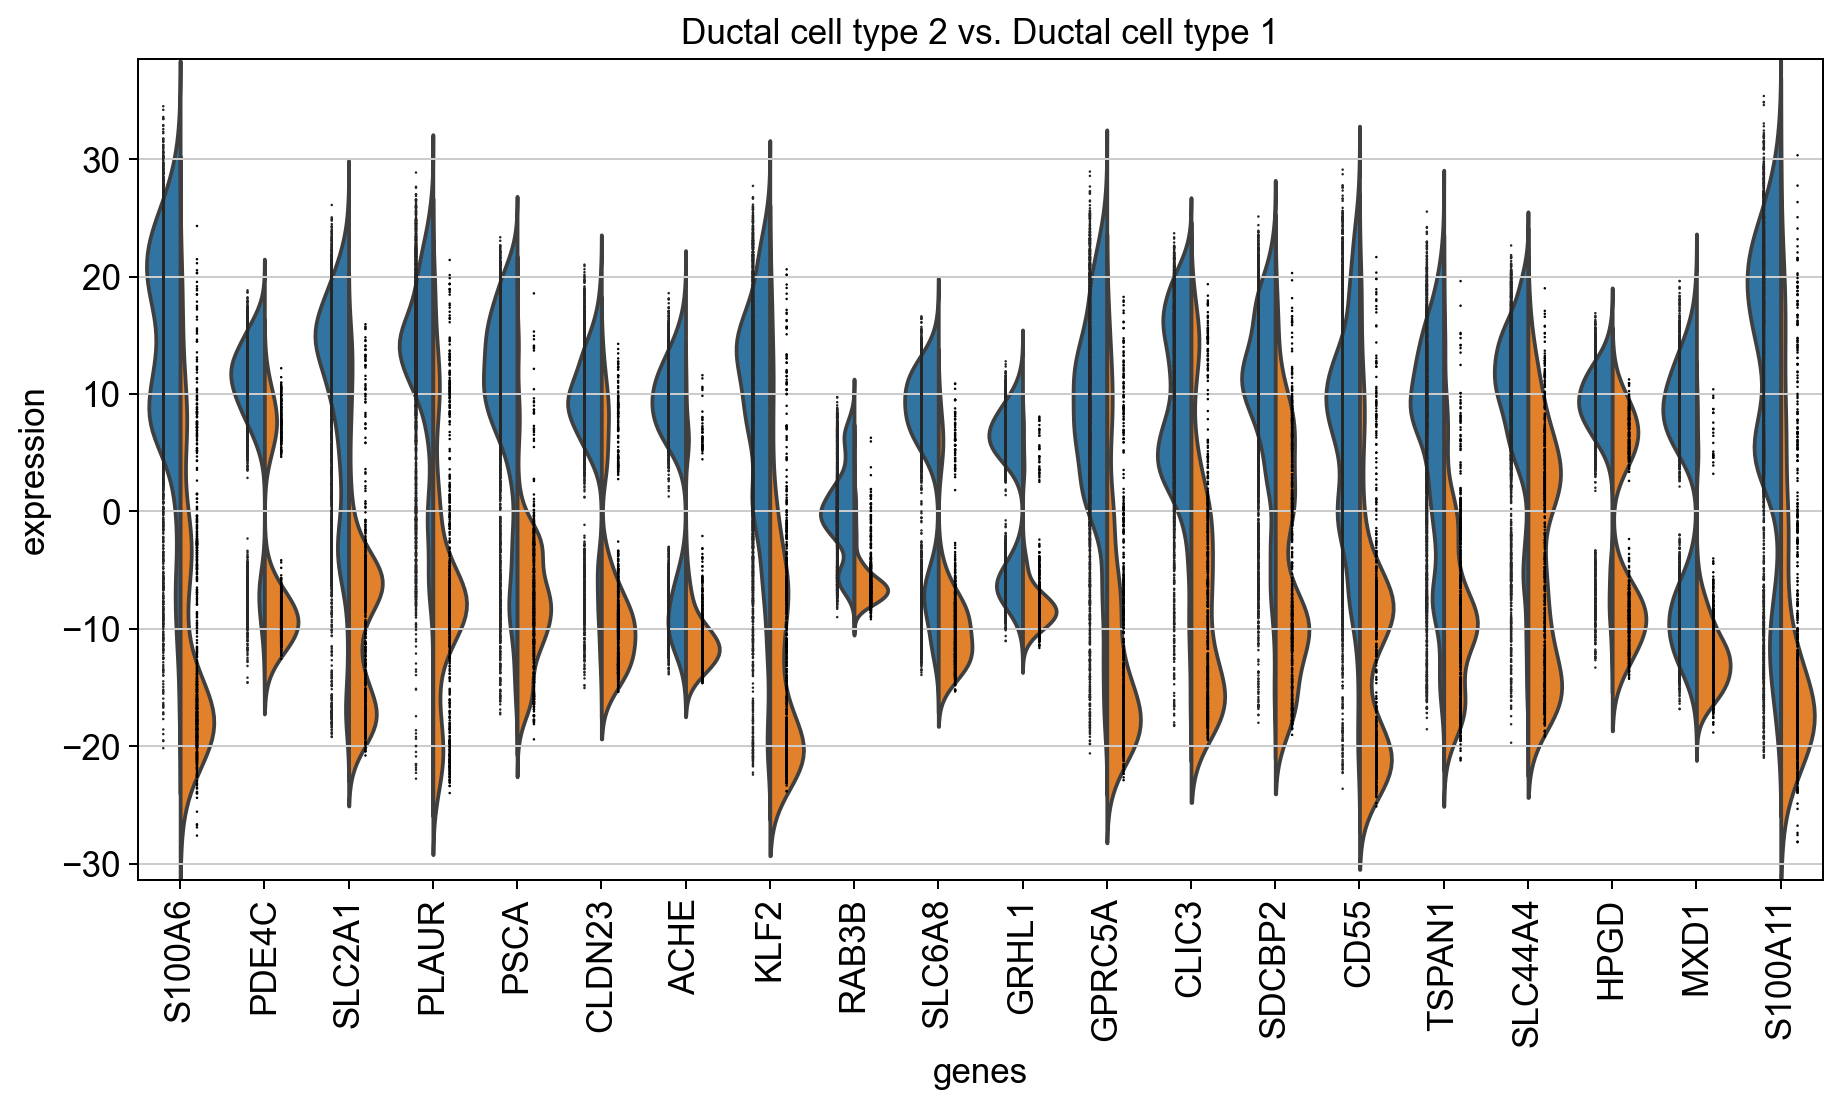

In [237]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))


sc.pl.rank_genes_groups_violin(adata_PA, groups="Ductal cell type 2", jitter=0 )

<code style="background:lightgreen">Consider removing this section if no such example will be shown</code>

In [ ]:
top_proteins_type1 = adata_PA.uns["rank_genes_groups"]["names"]
top_proteins_type1 = [str(item[0]) for item in top_proteins_type1.tolist()]


<code style="background:lightgreen">Pathway enrichment analysis</code>

In [255]:
hallmarks_MSigDB = pyther.load.msigdb_regulon('h') # load hallmark of cancer MSigDB as an interactome

In [256]:
pyther.viper(adata_PA, interactome=)

Help on function viper in module pyther._viper:

viper(gex_data, interactome, layer=None, eset_filter=True, method=None, enrichment='area', mvws=1, min_targets=30, njobs=1, batch_size=10000, verbose=True, output_as_anndata=True, transfer_obs=True, store_input_data=True)
    Allows the individual to infer normalized enrichment scores using Analytical
    Ranked Enrichment Analysis (aREA)[1] or Nonparametric Analytical Rank-based
    Enrichment Analysis (NaRnEA)[2]. NaRnEA also compute proportional enrichment
    scores.
    
    The Interactome object must not contain any targets that are not in the
    features of gex_data. This can be accomplished by running:
        interactome.filter_targets(gex_data.var_names)
    It is highly recommend to do this on the unPruned network and then prune to
    ensure the pruned network contains a consistent number of targets per
    regulator, allow of which exist within gex_data.
    
    Parameters
    ----------
    gex_data
        Gene expressi

Show how to use <span style="color:green">pyther.config.set_regulators_species_to_use(species="human")</span>